## fastai, pytorch, opencv, imageio are the main packages used to to this project

In [1]:
from fastai.basics import *
from fastai.vision.all import *
from fastai.data.transforms import *

In [2]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import glob

import nibabel as nib
import cv2
import imageio
from tqdm.notebook import tqdm
from ipywidgets import *
from PIL import Image

### The data is over 20GB, please make sure you have enough space to work on them

In [3]:
dir_list = ['segmentations', 'volume_pt1', 'volume_pt2', 'volume_pt3', 'volume_pt4', 
            'volume_pt5', 'archive/volume_pt6', 'archive/volume_pt8']
files = []
for folder in dir_list:
    for dirname,_, filenames in os.walk(folder):
        for filename in filenames:
            ## for some reason, the filenames what start with '._' did not show on the folder and we should skip them
            if not filename.startswith('._'):
                files.append((folder,filename))
len(files)

262

In [4]:
files[:10]

[('segmentations', 'segmentation-0.nii'),
 ('segmentations', 'segmentation-1.nii'),
 ('segmentations', 'segmentation-10.nii'),
 ('segmentations', 'segmentation-100.nii'),
 ('segmentations', 'segmentation-101.nii'),
 ('segmentations', 'segmentation-102.nii'),
 ('segmentations', 'segmentation-103.nii'),
 ('segmentations', 'segmentation-104.nii'),
 ('segmentations', 'segmentation-105.nii'),
 ('segmentations', 'segmentation-106.nii')]

In [5]:
df_files = pd.DataFrame(files, columns =['dirname', 'filename']) 
df_files.sort_values(by=['filename'], ascending=True)  
df_files.head()

,dirname,filename
0,segmentations,segmentation-0.nii
1,segmentations,segmentation-1.nii
2,segmentations,segmentation-10.nii
3,segmentations,segmentation-100.nii
4,segmentations,segmentation-101.nii


In [6]:
df_files.shape[0]

262

### Use files under 'segmentation' folder to be the masks 

In [7]:
# Map CT scan and label 

df_files["mask_dirname"]  = ""
df_files["mask_filename"] = ""

for i in range(131):
    ct = f"volume-{i}.nii"
    mask = f"segmentation-{i}.nii"
    
    df_files.loc[df_files['filename'] == ct, 'mask_filename'] = mask
    df_files.loc[df_files['filename'] == ct, 'mask_dirname'] = "segmentations"

# drop segment rows
df_files = df_files[df_files.mask_filename != ''].sort_values(by=['filename']).reset_index(drop=True) 

df_files.head()

,dirname,filename,mask_dirname,mask_filename
0,volume_pt1,volume-0.nii,segmentations,segmentation-0.nii
1,volume_pt1,volume-1.nii,segmentations,segmentation-1.nii
2,volume_pt1,volume-10.nii,segmentations,segmentation-10.nii
3,archive/volume_pt6,volume-100.nii,segmentations,segmentation-100.nii
4,archive/volume_pt8,volume-101.nii,segmentations,segmentation-101.nii


### This is to reads .nii file and returns pixel array

In [8]:
def read_nii(filepath):
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    return(array)

In [9]:
# Read sample

sample = 0
sample_ct = read_nii(df_files.loc[sample,'dirname']+"/"+df_files.loc[sample,'filename'])
sample_mask = read_nii(df_files.loc[sample,'mask_dirname']+"/"+df_files.loc[sample,'mask_filename'])

print(f'CT Shape:   {sample_ct.shape}\nMask Shape: {sample_mask.shape}')

CT Shape:   (512, 512, 75)
Mask Shape: (512, 512, 75)


### This is to print out the min and max value of arrays

In [10]:
print(np.amin(sample_ct), np.amax(sample_ct))
print(np.amin(sample_mask), np.amax(sample_mask))


-3024.0 1410.0
0.0 2.0


In [11]:
from matplotlib.pyplot import figure

### The code creates a windowed version of the sample_ct tensor, using the window level and width values for the 'liver' window from the dicom_windows object, and displays it using matplotlib's imshow function with a bone colormap.

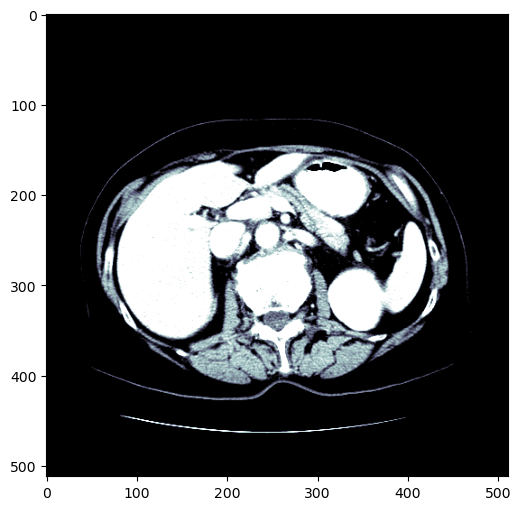

In [12]:
#store a set of named values that represent window level and width values 
#for various medical imaging modalities such as brain, subdural, stroke, brain_bone, brain_soft, 
#lungs, mediastinum, abdomen_soft, liver, spine_soft, spine_bone and custom.
dicom_windows = types.SimpleNamespace(
    brain=(80,40),
    subdural=(254,100),
    stroke=(8,32),
    brain_bone=(2800,600),
    brain_soft=(375,40),
    lungs=(1500,-600),
    mediastinum=(350,50),
    abdomen_soft=(400,50),
    liver=(150,30),
    spine_soft=(250,50),
    spine_bone=(1800,400),
    custom = (200,60)
)

@patch
def windowed(self:Tensor, w, l):
    px = self.clone()
    px_min = l - w//2
    px_max = l + w//2
    px[px<px_min] = px_min
    px[px>px_max] = px_max
    return (px-px_min) / (px_max-px_min)

figure(figsize=(8, 6), dpi=100)
plt.imshow(tensor(sample_ct[..., 55].astype(np.float32)).windowed(*dicom_windows.liver), cmap=plt.cm.bone);

In [13]:
def plot_sample(array_list, color_map = 'nipy_spectral'):
    '''
    Plots and a slice with all available annotations
    '''
    fig = plt.figure(figsize=(18,15))

    #This subplot shows the original image using the 'bone' colormap.
    plt.subplot(1,4,1)
    plt.imshow(array_list[0], cmap='bone')
    plt.title('Original Image')
    
    #This subplot shows a windowed version of the image using the window level and width values 
    #for the 'liver' window from the dicom_windows object and the 'bone' colormap
    plt.subplot(1,4,2)
    plt.imshow(tensor(array_list[0].astype(np.float32)).windowed(*dicom_windows.liver), cmap='bone');
    plt.title('Windowed Image')
    
    #This subplot shows a mask image using the color map passed as the second 
    #argument (default is 'nipy_spectral')
    plt.subplot(1,4,3)
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Mask')
    
    #This subplot shows both the original image and the mask image overlayed on top of 
    #each other using the 'bone' colormap for the original image and the color map passed as 
    #the second argument for the mask.
    plt.subplot(1,4,4)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.title('Liver & Mask')


    plt.show()

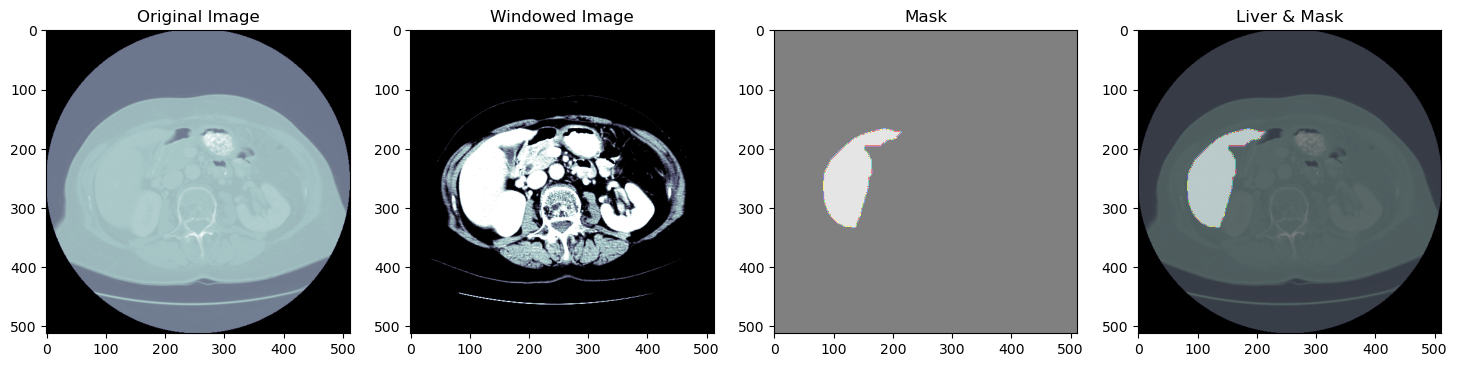

In [14]:
sample=50
sample_slice = tensor(sample_ct[...,sample].astype(np.float32))

plot_sample([sample_ct[...,sample], sample_mask[...,sample]])

In [15]:
# Check the mask values
mask = Image.fromarray(sample_mask[...,sample].astype('uint8'), mode="L")
unique, counts = np.unique(mask, return_counts=True)
print( np.array((unique, counts)).T)

[[     0 252049]
 [     1  10095]]


##### 1. This code defines a custom class TensorCTScan that inherits from the TensorImageBW class and sets the default colormap to 'bone' when displaying the image.

##### 2. It also defines three patches to the Tensor class, adding new methods to the class.

##### 3.The first method is freqhist_bins which takes an optional argument n_bins (default is 100) and is used to split the range of pixel values into groups, such that each group has around the same number of pixels. It returns an array of unique values that represents the breaks of the bins.

##### 4.The second method is hist_scaled which takes an optional argument brks (default is None) and scales the tensor using the freqhist_bins method to values between 0 and 1. If brks is passed, it uses it as the breaks of the bins instead of calling freqhist_bins.

##### 5.The third method is to_nchan which takes a Tensor, a list of window level and width values and an optional argument bins(default is None) and returns a TensorCTScan object, which is a stack of the windowed images and the hist_scaled image, if the bins argument is not None.

##### 6. The fourth method is save_jpg which takes a Tensor, a file path, a list of window level and width values and an optional argument bins(default is None) and quality(default is 90), converts the TensorCTScan object to RGB mode, saves it to the file path and quality provided, and opens it using the PIL's Image.open method.

##### 7.The last code snippet is using the save_jpg method to save the image to test.jpg with the window level and width values of 'liver' and 'custom' from dicom_windows object and then it's displaying the saved image using the show_image function from fastai library with the matplotlib's subplots.

<AxesSubplot:>

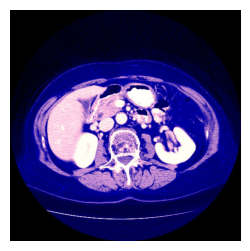

In [16]:
# Preprocessing functions
class TensorCTScan(TensorImageBW): _show_args = {'cmap':'bone'}

@patch
def freqhist_bins(self:Tensor, n_bins=100):
    "A function to split the range of pixel values into groups, such that each group has around the same number of pixels"
    imsd = self.view(-1).sort()[0]
    t = torch.cat([tensor([0.001]),
                   torch.arange(n_bins).float()/n_bins+(1/2/n_bins),
                   tensor([0.999])])
    t = (len(imsd)*t).long()
    return imsd[t].unique()

@patch
def hist_scaled(self:Tensor, brks=None):
    "Scales a tensor using `freqhist_bins` to values between 0 and 1"
    if self.device.type=='cuda': return self.hist_scaled_pt(brks)
    if brks is None: brks = self.freqhist_bins()
    ys = np.linspace(0., 1., len(brks))
    x = self.numpy().flatten()
    x = np.interp(x, brks.numpy(), ys)
    return tensor(x).reshape(self.shape).clamp(0.,1.)

@patch
def to_nchan(x:Tensor, wins, bins=None):
    res = [x.windowed(*win) for win in wins]
    if not isinstance(bins,int) or bins!=0: res.append(x.hist_scaled(bins).clamp(0,1))
    dim = [0,1][x.dim()==3]
    return TensorCTScan(torch.stack(res, dim=dim))

@patch
def save_jpg(x:(Tensor), path, wins, bins=None, quality=90):
    fn = Path(path).with_suffix('.jpg')
    x = (x.to_nchan(wins, bins)*255).byte()
    im = Image.fromarray(x.permute(1,2,0).numpy(), mode=['RGB','CMYK'][x.shape[0]==4])
    im.save(fn, quality=quality)
    
_,axs=subplots(1,1)

sample_slice.save_jpg('test.jpg', [dicom_windows.liver,dicom_windows.custom])
show_image(Image.open('test.jpg'), ax=axs[0])

In [ ]:
GENERATE_JPG_FILES = True   # warning: generation takes ~ 3h

if (GENERATE_JPG_FILES) :
    
    path = Path(".")

    os.makedirs('train_images',exist_ok=True)
    os.makedirs('train_masks',exist_ok=True)

    for ii in tqdm(range(0,len(df_files),3)): # take 1/3 nii files for training
        curr_ct        = read_nii(df_files.loc[ii,'dirname']+"/"+df_files.loc[ii,'filename'])
        curr_mask      = read_nii(df_files.loc[ii,'mask_dirname']+"/"+df_files.loc[ii,'mask_filename'])
        curr_file_name = str(df_files.loc[ii,'filename']).split('.')[0]
        curr_dim       = curr_ct.shape[2] # 512, 512, curr_dim
        
        for curr_slice in range(0,curr_dim,2): # export every 2nd slice for training
            data = tensor(curr_ct[...,curr_slice].astype(np.float32))
            mask = Image.fromarray(curr_mask[...,curr_slice].astype('uint8'), mode="L")
            data.save_jpg(f"train_images/{curr_file_name}_slice_{curr_slice}.jpg", [dicom_windows.liver,dicom_windows.custom])
            mask.save(f"train_masks/{curr_file_name}_slice_{curr_slice}_mask.png")
else:
    
    path = Path("archive") # read jpg from saved kernel output

  0%|          | 0/44 [00:00<?, ?it/s]

####  1. This is defining a function to create a DataBlock for loading and transforming a dataset of CT scans for liver and tumor segmentation.
##### 2. The first lines define the batch size (bs) as 16 and the image size (im_size) as 128. The next line creates a codes array which will be used to map class labels to integers.

##### 3. The get_x function takes in a file path and return the file path as the input.
##### 4. The label_func function takes the input file path and returns the corresponding label file path by appending the '_mask.png' to the input file name.

##### 5. The tfms variable is a list of transformers to be applied to the data. It includes converting the input image to a float tensor and normalizing the pixel values.

##### 6. The db variable is an instance of DataBlock, which is a class used to organize and preprocess the data. 

In [18]:
path = Path(".")

In [19]:
bs = 16
im_size = 128

codes = np.array(["background","liver","tumor"])
    
def get_x(fname:Path): return fname
def label_func(x): return path/'train_masks'/f'{x.stem}_mask.png'

tfms = [IntToFloatTensor(),Normalize()]
db = DataBlock(blocks=(ImageBlock(),MaskBlock(codes)),  #codes = {"Backround": 0,"Liver": 1,"Tumor": 2}
               batch_tfms=tfms,
               splitter=RandomSplitter(),
               item_tfms=[Resize(im_size)],
               get_items=get_image_files,
               get_y=label_func
              )

ds = db.datasets(source=path/'train_images')

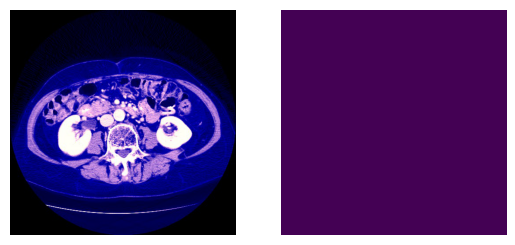

In [20]:
idx=20
imgs = [ds[idx][0],ds[idx][1]]
fig,axs = plt.subplots(1, 2)
for i,ax in enumerate(axs.flatten()):
    ax.axis('off')
    ax.imshow(imgs[i]) #, cmap='gray'

In [21]:
unique, counts = np.unique(array(ds[idx][1]), return_counts=True)

print( np.array((unique, counts)).T)

[[     0 262144]]


#### creating a DataLoader object (dls) from a dataset to display a batch of images from the dataset

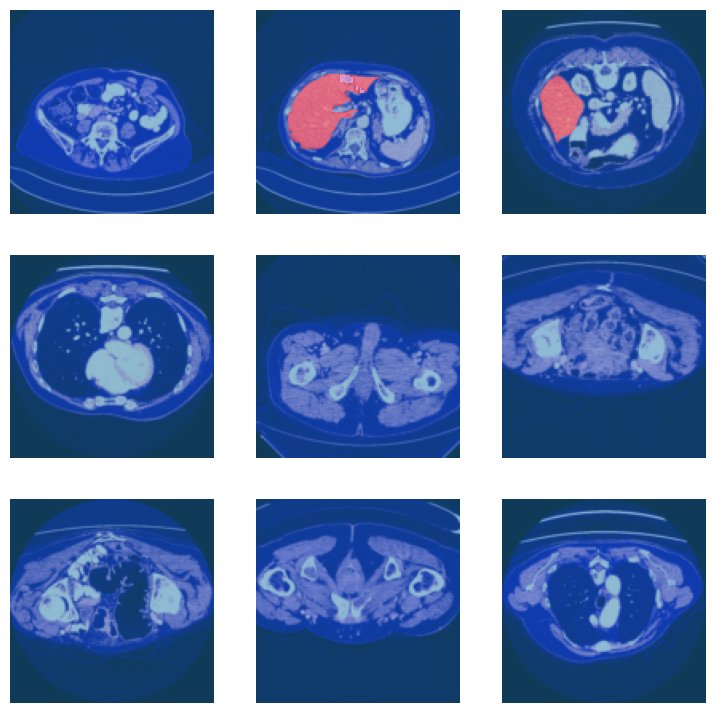

In [22]:
dls = db.dataloaders(path/'train_images',bs = bs) #, num_workers=0
dls.show_batch()

In [23]:
#this function is used to calculate the accuracy of a multiclass image segmentation model, 
#but excludes the background class from the calculation.
def foreground_acc(inp, targ, bkg_idx=0, axis=1):  # exclude a background from metric
    "Computes non-background accuracy for multiclass segmentation"
    targ = targ.squeeze(1)
    mask = targ != bkg_idx
    return (inp.argmax(dim=axis)[mask]==targ[mask]).float().mean() 


#It calls the "foreground_acc" function, but with the "bkg_idx" argument set to 3 instead of 0. 
#This means that the background class (which is typically indexed as 0) will now be included in 
#the accuracy calculation.
#It should be noted that the specific value of "3" is used as a dummy value to include the background, 
#which is indexed as 0 in the input tensors.
def cust_foreground_acc(inp, targ):  # # include a background into the metric
    return foreground_acc(inp=inp, targ=targ, bkg_idx=3, axis=1) # 3 is a dummy value to include the background which is 0

In [24]:
learn = unet_learner(dls, resnet34, loss_func=CrossEntropyLossFlat(axis=1), metrics=[foreground_acc, cust_foreground_acc]) 

/Users/Wenhuan/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/Wenhuan/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [26]:
# This take more than 20 hours to execute and it finally crashed. 
#learn.fine_tune(5, wd=0.1, cbs=SaveModelCallback())

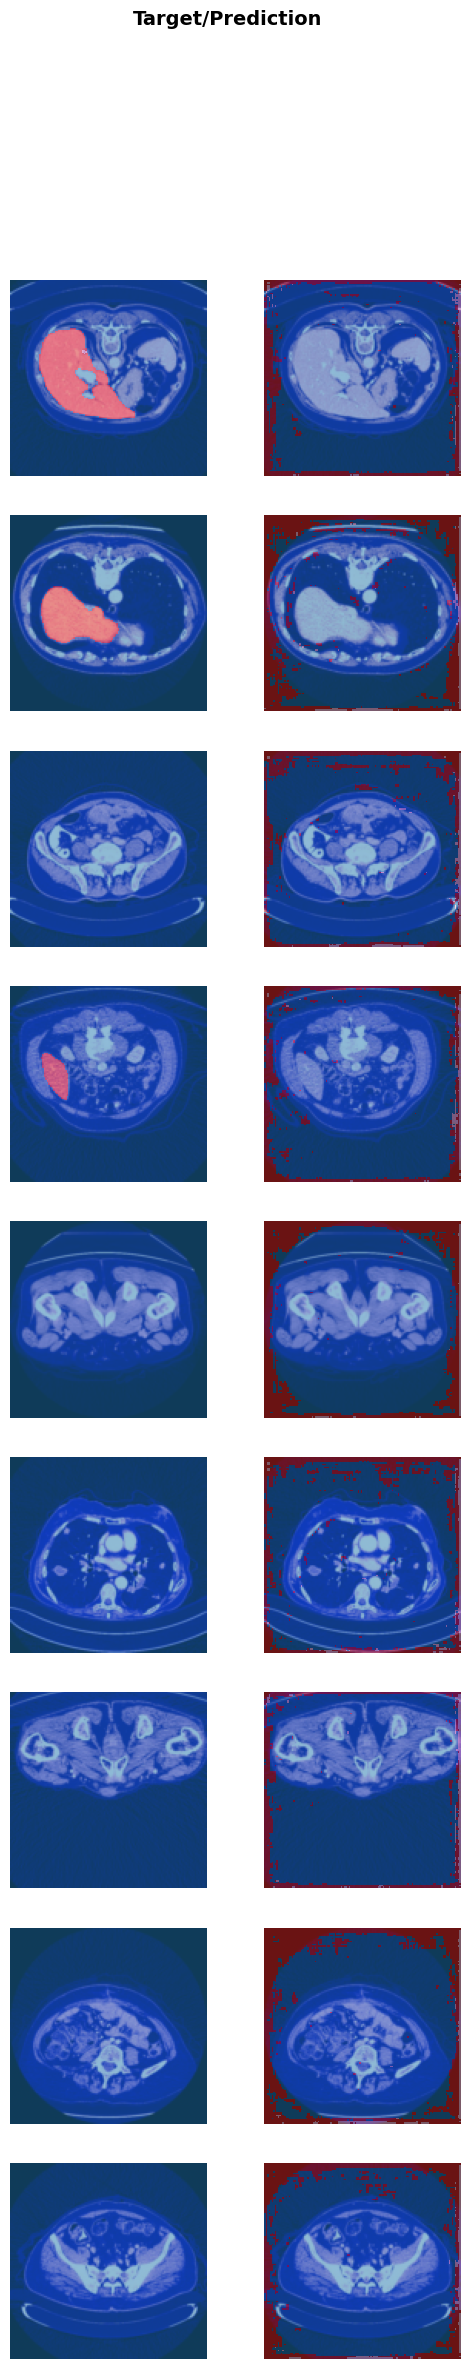

In [27]:
learn.show_results()